# GOOGL stock 'Close' value prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Stock data function configured to drop all columns except 'Open','High' and 'Close'

In [2]:
def get_stock_data(stock_name, normalized=0):
    
  
    col_names = ['Date','Open','High','Low','Close','Adj Close','Volume']
    stocks = pd.read_csv("./GOOG.csv", header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    df.drop(df.columns[[3,5,6]], axis=1, inplace=True) 
    df.set_index(df.columns[0], inplace=True)
    return df

## Loading GOOGL stock data from yahoo.com

In [3]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,0)
df.tail()

,Open,High,Close
Date,,,
2018-05-21,1074.060059,1088.000000,1079.579956
2018-05-22,1083.560059,1086.589966,1069.729980
2018-05-23,1065.130005,1080.780029,1079.689941
2018-05-24,1079.000000,1080.469971,1079.239990
2018-05-25,1079.020020,1082.560059,1075.660034


# Normalize Data

In [4]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
    #df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    #df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.tail()

,Open,High,Close
Date,,,
2018-05-21,0.908453,0.912976,0.914524
2018-05-22,0.916875,0.911735,0.905777
2018-05-23,0.900537,0.906622,0.914621
2018-05-24,0.912832,0.906349,0.914222
2018-05-25,0.912850,0.908188,0.911043


## Saving the data to a file for a future use

In [5]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [6]:
# df['High'] = df['High'] / 1000
# df['Open'] = df['Open'] / 1000
# df['Close'] = df['Close'] / 1000
# df.head(5)
# df.tail()

## Updated load_data function from lstm.py, configured to accept any amount of features.
## It is set to calculate the last feature as a result.

In [7]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


## Building model functions

In [8]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(32,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='linear'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [9]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3115, 5, 3)
y_train (3115,)
X_test (346, 5, 3)
y_test (346,)


## Loading the model sequence structure

In [10]:
# model = build_model([3,lag,1])
model = build_model2([3,window,1])

## Executing the model & RMS/RMSE results

In [11]:
tb= keras.callbacks.TensorBoard(log_dir='/notebooks/logs/lstm_stock/google/relu_linear', histogram_freq=10, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=500,
    validation_split=0.2,
    verbose=1,callbacks=[tb])

Train on 2492 samples, validate on 623 samples
Epoch 1/500
2492/2492 [==============================] - 4s 2ms/step - loss: 0.0435 - acc: 0.0000e+00 - val_loss: 1.4618e-04 - val_acc: 0.0000e+00
Epoch 2/500
2492/2492 [==============================] - 2s 989us/step - loss: 0.0012 - acc: 4.0128e-04 - val_loss: 1.6493e-04 - val_acc: 0.0000e+00
Epoch 3/500
2492/2492 [==============================] - 2s 811us/step - loss: 0.0012 - acc: 4.0128e-04 - val_loss: 1.0332e-04 - val_acc: 0.0000e+00
Epoch 4/500
2492/2492 [==============================] - 2s 868us/step - loss: 0.0012 - acc: 4.0128e-04 - val_loss: 9.9163e-05 - val_acc: 0.0000e+00
Epoch 5/500
2492/2492 [==============================] - 2s 753us/step - loss: 0.0012 - acc: 4.0128e-04 - val_loss: 9.3178e-05 - val_acc: 0.0000e+00
Epoch 6/500
2492/2492 [==============================] - 2s 873us/step - loss: 9.9820e-04 - acc: 4.0128e-04 - val_loss: 8.8588e-05 - val_acc: 0.0000e+00
Epoch 7/500
2492/2492 [==============================] - 

2492/2492 [==============================] - 2s 726us/step - loss: 4.0621e-04 - acc: 4.0128e-04 - val_loss: 5.5364e-05 - val_acc: 0.0000e+00
Epoch 55/500
2492/2492 [==============================] - 2s 703us/step - loss: 3.6818e-04 - acc: 4.0128e-04 - val_loss: 4.9976e-05 - val_acc: 0.0000e+00
Epoch 56/500
2492/2492 [==============================] - 2s 780us/step - loss: 4.7069e-04 - acc: 4.0128e-04 - val_loss: 4.3905e-05 - val_acc: 0.0000e+00
Epoch 57/500
2492/2492 [==============================] - 2s 748us/step - loss: 3.8357e-04 - acc: 4.0128e-04 - val_loss: 5.2230e-05 - val_acc: 0.0000e+00
Epoch 58/500
2492/2492 [==============================] - 2s 743us/step - loss: 3.4294e-04 - acc: 4.0128e-04 - val_loss: 7.5754e-05 - val_acc: 0.0000e+00
Epoch 59/500
2492/2492 [==============================] - 2s 716us/step - loss: 3.7742e-04 - acc: 4.0128e-04 - val_loss: 7.8391e-05 - val_acc: 0.0000e+00
Epoch 60/500
2492/2492 [==============================] - 3s 1ms/step - loss: 3.7394e-04 

2492/2492 [==============================] - 2s 747us/step - loss: 2.6301e-04 - acc: 4.0128e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 108/500
2492/2492 [==============================] - 2s 707us/step - loss: 2.2985e-04 - acc: 4.0128e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 109/500
2492/2492 [==============================] - 2s 713us/step - loss: 2.1467e-04 - acc: 4.0128e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 110/500
2492/2492 [==============================] - 2s 870us/step - loss: 2.3178e-04 - acc: 4.0128e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 111/500
2492/2492 [==============================] - 2s 741us/step - loss: 2.3446e-04 - acc: 4.0128e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 112/500
2492/2492 [==============================] - 2s 701us/step - loss: 2.3611e-04 - acc: 4.0128e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 113/500
2492/2492 [==============================] - 2s 694us/step - loss: 2.5675e-04 - acc: 4.0128e-0

2492/2492 [==============================] - 2s 714us/step - loss: 1.6467e-04 - acc: 4.0128e-04 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 162/500
2492/2492 [==============================] - 2s 720us/step - loss: 1.4247e-04 - acc: 4.0128e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 163/500
2492/2492 [==============================] - 3s 1ms/step - loss: 1.5835e-04 - acc: 4.0128e-04 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 164/500
2492/2492 [==============================] - 2s 724us/step - loss: 1.4589e-04 - acc: 4.0128e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 165/500
2492/2492 [==============================] - 2s 697us/step - loss: 1.5386e-04 - acc: 4.0128e-04 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 166/500
2492/2492 [==============================] - 2s 726us/step - loss: 1.5889e-04 - acc: 4.0128e-04 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 167/500
2492/2492 [==============================] - 2s 724us/step - loss: 1.5893e-04 - acc: 4.0128e-04 

2492/2492 [==============================] - 2s 700us/step - loss: 1.5929e-04 - acc: 4.0128e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 216/500
2492/2492 [==============================] - 2s 697us/step - loss: 1.4095e-04 - acc: 4.0128e-04 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 217/500
2492/2492 [==============================] - 2s 710us/step - loss: 1.3269e-04 - acc: 4.0128e-04 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 218/500
2492/2492 [==============================] - 2s 704us/step - loss: 1.3202e-04 - acc: 4.0128e-04 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 219/500
2492/2492 [==============================] - 2s 701us/step - loss: 1.5364e-04 - acc: 4.0128e-04 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 220/500
2492/2492 [==============================] - 2s 717us/step - loss: 1.3879e-04 - acc: 4.0128e-04 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 221/500
2492/2492 [==============================] - 2s 712us/step - loss: 1.2366e-04 - acc: 4.0128e-0

2492/2492 [==============================] - 2s 730us/step - loss: 1.2639e-04 - acc: 4.0128e-04 - val_loss: 0.0067 - val_acc: 0.0000e+00
Epoch 270/500
2492/2492 [==============================] - 2s 716us/step - loss: 1.2408e-04 - acc: 4.0128e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 271/500
2492/2492 [==============================] - 2s 765us/step - loss: 1.3568e-04 - acc: 4.0128e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 272/500
2492/2492 [==============================] - 2s 757us/step - loss: 1.2160e-04 - acc: 4.0128e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 273/500
2492/2492 [==============================] - 2s 727us/step - loss: 1.2760e-04 - acc: 4.0128e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 274/500
2492/2492 [==============================] - 2s 754us/step - loss: 1.0643e-04 - acc: 4.0128e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 275/500
2492/2492 [==============================] - 2s 716us/step - loss: 1.2855e-04 - acc: 4.0128e-0

2492/2492 [==============================] - 2s 741us/step - loss: 1.0709e-04 - acc: 4.0128e-04 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 324/500
2492/2492 [==============================] - 2s 701us/step - loss: 1.0678e-04 - acc: 4.0128e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 325/500
2492/2492 [==============================] - 2s 713us/step - loss: 9.6131e-05 - acc: 4.0128e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 326/500
2492/2492 [==============================] - 2s 769us/step - loss: 1.0580e-04 - acc: 4.0128e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 327/500
2492/2492 [==============================] - 3s 1ms/step - loss: 1.1878e-04 - acc: 4.0128e-04 - val_loss: 0.0092 - val_acc: 0.0000e+00
Epoch 328/500
2492/2492 [==============================] - 2s 733us/step - loss: 1.1306e-04 - acc: 4.0128e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 329/500
2492/2492 [==============================] - 2s 715us/step - loss: 1.0218e-04 - acc: 4.0128e-04 

2492/2492 [==============================] - 2s 744us/step - loss: 1.0984e-04 - acc: 4.0128e-04 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 378/500
2492/2492 [==============================] - 2s 715us/step - loss: 1.0289e-04 - acc: 4.0128e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 379/500
2492/2492 [==============================] - 2s 792us/step - loss: 1.0939e-04 - acc: 4.0128e-04 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 380/500
2492/2492 [==============================] - 3s 1ms/step - loss: 9.5013e-05 - acc: 4.0128e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 381/500
2492/2492 [==============================] - 2s 761us/step - loss: 1.0255e-04 - acc: 4.0128e-04 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 382/500
2492/2492 [==============================] - 2s 714us/step - loss: 9.4634e-05 - acc: 4.0128e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 383/500
2492/2492 [==============================] - 2s 742us/step - loss: 9.3182e-05 - acc: 4.0128e-04 

2492/2492 [==============================] - 3s 1ms/step - loss: 9.1706e-05 - acc: 4.0128e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 432/500
2492/2492 [==============================] - 2s 964us/step - loss: 8.3340e-05 - acc: 4.0128e-04 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 433/500
2492/2492 [==============================] - 2s 916us/step - loss: 8.8448e-05 - acc: 4.0128e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 434/500
2492/2492 [==============================] - 2s 884us/step - loss: 9.4666e-05 - acc: 4.0128e-04 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 435/500
2492/2492 [==============================] - 2s 851us/step - loss: 9.9740e-05 - acc: 4.0128e-04 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 436/500
2492/2492 [==============================] - 3s 1ms/step - loss: 8.6573e-05 - acc: 4.0128e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 437/500
2492/2492 [==============================] - 4s 2ms/step - loss: 9.1473e-05 - acc: 4.0128e-04 - va

2492/2492 [==============================] - 3s 1ms/step - loss: 9.6845e-05 - acc: 4.0128e-04 - val_loss: 0.0087 - val_acc: 0.0000e+00
Epoch 486/500
2492/2492 [==============================] - 2s 905us/step - loss: 7.7984e-05 - acc: 4.0128e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 487/500
2492/2492 [==============================] - 2s 699us/step - loss: 7.8529e-05 - acc: 4.0128e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 488/500
2492/2492 [==============================] - 2s 705us/step - loss: 8.1542e-05 - acc: 4.0128e-04 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 489/500
2492/2492 [==============================] - 2s 715us/step - loss: 9.4085e-05 - acc: 4.0128e-04 - val_loss: 0.0102 - val_acc: 0.0000e+00
Epoch 490/500
2492/2492 [==============================] - 2s 710us/step - loss: 9.2041e-05 - acc: 4.0128e-04 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 491/500
2492/2492 [==============================] - 2s 716us/step - loss: 7.8665e-05 - acc: 4.0128e-04 

In [12]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.08 RMSE)
Test Score: 0.01 MSE (0.10 RMSE)


In [13]:
print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

[[0.00392375 0.00300768 0.00270847]
 [0.00253657 0.00271478 0.00348484]
 [0.00254097 0.00273664 0.0026423 ]
 [0.00530653 0.00431042 0.00214384]
 [0.00509075 0.00513228 0.0041421 ]]


## Predictions vs Real results

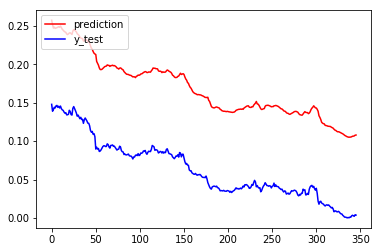

In [14]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

# Load New Data, completely untrained
I mean stocks should behave the same right?

In [15]:
col_names = ['Date','Open','High','Low','Close','Adj Close','Volume']
stocks = pd.read_csv("./TSM.csv", header=0, names=col_names) 
df2 = pd.DataFrame(stocks)
df2.drop(df2.columns[[3,5,6]], axis=1, inplace=True) 
df2.set_index(df2.columns[0], inplace=True)
print(df2)

df2 = normalize_data(df2)
df2.tail()
    
    
window = 5
X_train, y_train, X_test, y_test = load_data(df2[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

                 Open       High      Close
Date                                       
1997-10-09   5.646040   6.562691   6.323565
1997-10-10   7.014374   7.040944   6.615830
1997-10-13   6.629115   6.629115   6.469697
1997-10-14   6.416558   6.429843   6.204001
1997-10-15   5.818742   6.044584   6.031299
1997-10-16   6.031299   6.031299   5.845312
1997-10-17   5.579616   5.592901   5.340489
1997-10-20   4.463693   4.782528   4.676250
1997-10-21   4.888806   5.340489   5.340489
1997-10-22   4.915376   4.928661   4.716104
1997-10-23   4.569971   4.569971   4.437123
1997-10-24   4.543402   4.569971   4.197997
1997-10-27   4.091718   4.091718   3.640035
1997-10-28   3.347769   4.463693   4.463693
1997-10-29   4.091718   4.211282   4.051864
1997-10-30   3.826022   3.985440   3.945585
1997-10-31   4.091718   4.290990   4.197997
1997-11-03   4.569971   4.888806   4.822382
1997-11-04   4.782528   4.875522   4.822382
1997-11-05   4.915376   5.247496   5.207642
1997-11-06   5.393629   5.420198

In [16]:
print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

[[0.0587024  0.05606374 0.05215989]
 [0.06909761 0.06616255 0.06381918]
 [0.06420574 0.06646857 0.06811469]
 [0.07796412 0.07534329 0.07210338]
 [0.08285599 0.07993366 0.07823984]]


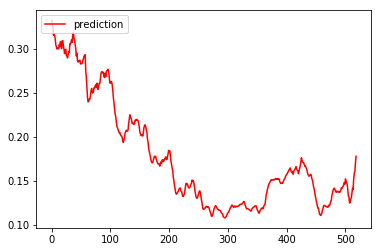

In [17]:
plt2.plot(p,color='red', label='prediction')

plt2.legend(loc='upper left')
plt2.show()

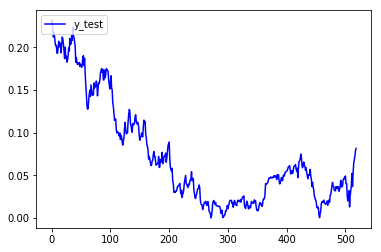

In [18]:
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

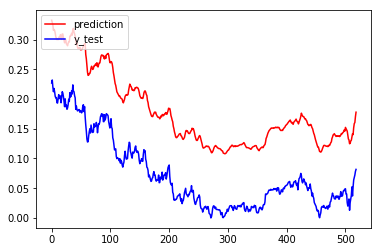

In [19]:
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()